In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import os
import statsmodels.api as sm
import statsmodels.formula.api as smf
import xlsxwriter
import matplotlib.colors as mcolors
import matplotlib as mpl



In [3]:
duke_gyri_data = 'Gyrification/merged_PTSD_ICV_Duke.xlsx'
df = pd.read_excel(duke_gyri_data)
df.head()

,ID,site,subject,ICV,sex,age,race,Ethnicity,currentPTSD_dx,currentPTSD_sev,...,rh.rostralanteriorcingulate,rh.rostralmiddlefrontal,rh.superiorfrontal,rh.superiorparietal,rh.superiortemporal,rh.supramarginal,rh.frontalpole,rh.temporalpole,rh.transversetemporal,rh.insula
0,10588814,Duke,1058,1486316.0,M,31.0,W,NaN,0.0,NaN,...,576.5,6455.8,7602.1,5650.1,3937.9,3942.5,333.8,474.2,389.4,2642.8
1,12588326,Duke,12588326,1468101.0,M,NaN,NaN,NaN,NaN,24.0,...,622.3,6376.8,6456.4,5024.9,3352.8,3171.4,320.7,381.0,319.6,1761.6
2,12947,Duke,12947,1877070.0,M,40.0,W,NH,1.0,65.0,...,667.7,6759.0,9526.3,5493.6,4220.0,3539.2,355.4,606.3,411.9,2849.6
3,12966,Duke,12966,1580526.0,M,36.0,W,NH,1.0,77.0,...,732.6,6330.9,7324.5,5055.5,4322.3,3506.7,322.1,515.7,363.8,2889.8
4,13070,Duke,13070,NaN,M,42.0,B,NH,NaN,27.0,...,738.9,6139.2,6769.0,4555.3,3018.5,3451.3,259.7,451.0,289.5,2501.3


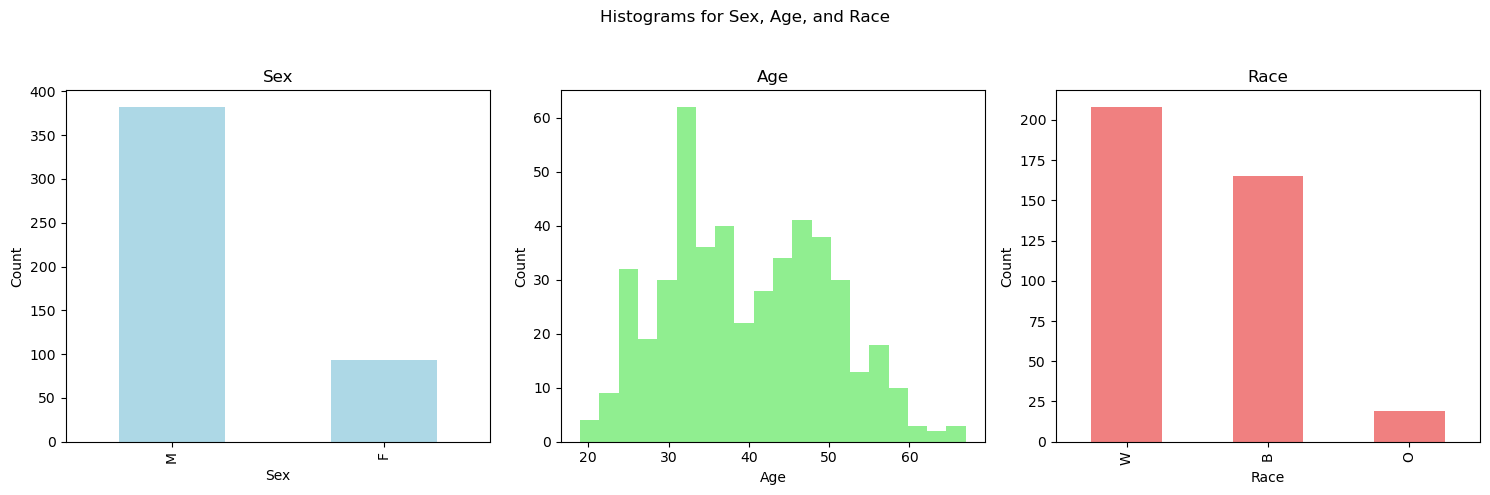

In [4]:
# Create histograms for Sex, Age, and Race
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Histograms for Sex, Age, and Race')

# Histogram for Sex
df['sex'].value_counts().plot(kind='bar', ax=axes[0], color='lightblue')
axes[0].set_title('Sex')
axes[0].set_xlabel('Sex')
axes[0].set_ylabel('Count')

# Histogram for Age
df['age'].plot(kind='hist', bins=20, ax=axes[1], color='lightgreen')
axes[1].set_title('Age')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Count')

# Histogram for Race
df['race'].value_counts().plot(kind='bar', ax=axes[2], color='lightcoral')
axes[2].set_title('Race')
axes[2].set_xlabel('Race')
axes[2].set_ylabel('Count')

# Display the histograms
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [9]:
# Define the function to perform GLM and extract ROIs with significant p-values for harmon_curr_ptsd_sev
def perform_glm_significant_for_harmon_curr_ptsd_sev(df):

    independent_vars = ['ICV', 'sex', 'age', 'harmon_curr_ptsd_sev']
    
    # Filter columns that start with "lh." or "rh."
    brain_columns = [col for col in df.columns if col.startswith('lh.') or col.startswith('rh.')]
    
    # Rename the columns to replace periods with underscores
    df = df.rename(columns=lambda col: col.replace('.', '_'))
    brain_columns = [col.replace('.', '_') for col in brain_columns]
    
    # Initialize an empty list to store ROIs with significant p-values for harmon_curr_ptsd_sev
    rois_with_significant_pvalues_for_harmon_curr_ptsd_sev = []
    
    # Loop through each brain column and perform GLM
    for brain_col in brain_columns:
        # Exclude rows with missing data in the dependent or independent variables
        filtered_df = df[[brain_col] + independent_vars].dropna()
        
        # Create the formula for the GLM
        formula = f'{brain_col} ~ ICV + C(sex) + age + harmon_curr_ptsd_sev'
        
        # Perform GLM
        model = smf.glm(formula, data=filtered_df, family=sm.families.Gaussian()).fit()
        
        # Check p-values for harmon_curr_ptsd_sev
        pvalue_harmon_curr_ptsd_sev = model.pvalues.get('harmon_curr_ptsd_sev', 1)
        
        # Add ROI to the list if it has significant p-values for harmon_curr_ptsd_sev
        if pvalue_harmon_curr_ptsd_sev < 0.05:
            rois_with_significant_pvalues_for_harmon_curr_ptsd_sev.append(brain_col)
    
    return rois_with_significant_pvalues_for_harmon_curr_ptsd_sev

# Run the function on the dataset and list the ROIs with significant p-values for harmon_curr_ptsd_sev
rois_with_significant_pvalues_for_harmon_curr_ptsd_sev = perform_glm_significant_for_harmon_curr_ptsd_sev(df)
rois_with_significant_pvalues_for_harmon_curr_ptsd_sev


['lh_precuneus',
 'rh_caudalmiddlefrontal',
 'rh_pericalcarine',
 'rh_postcentral']

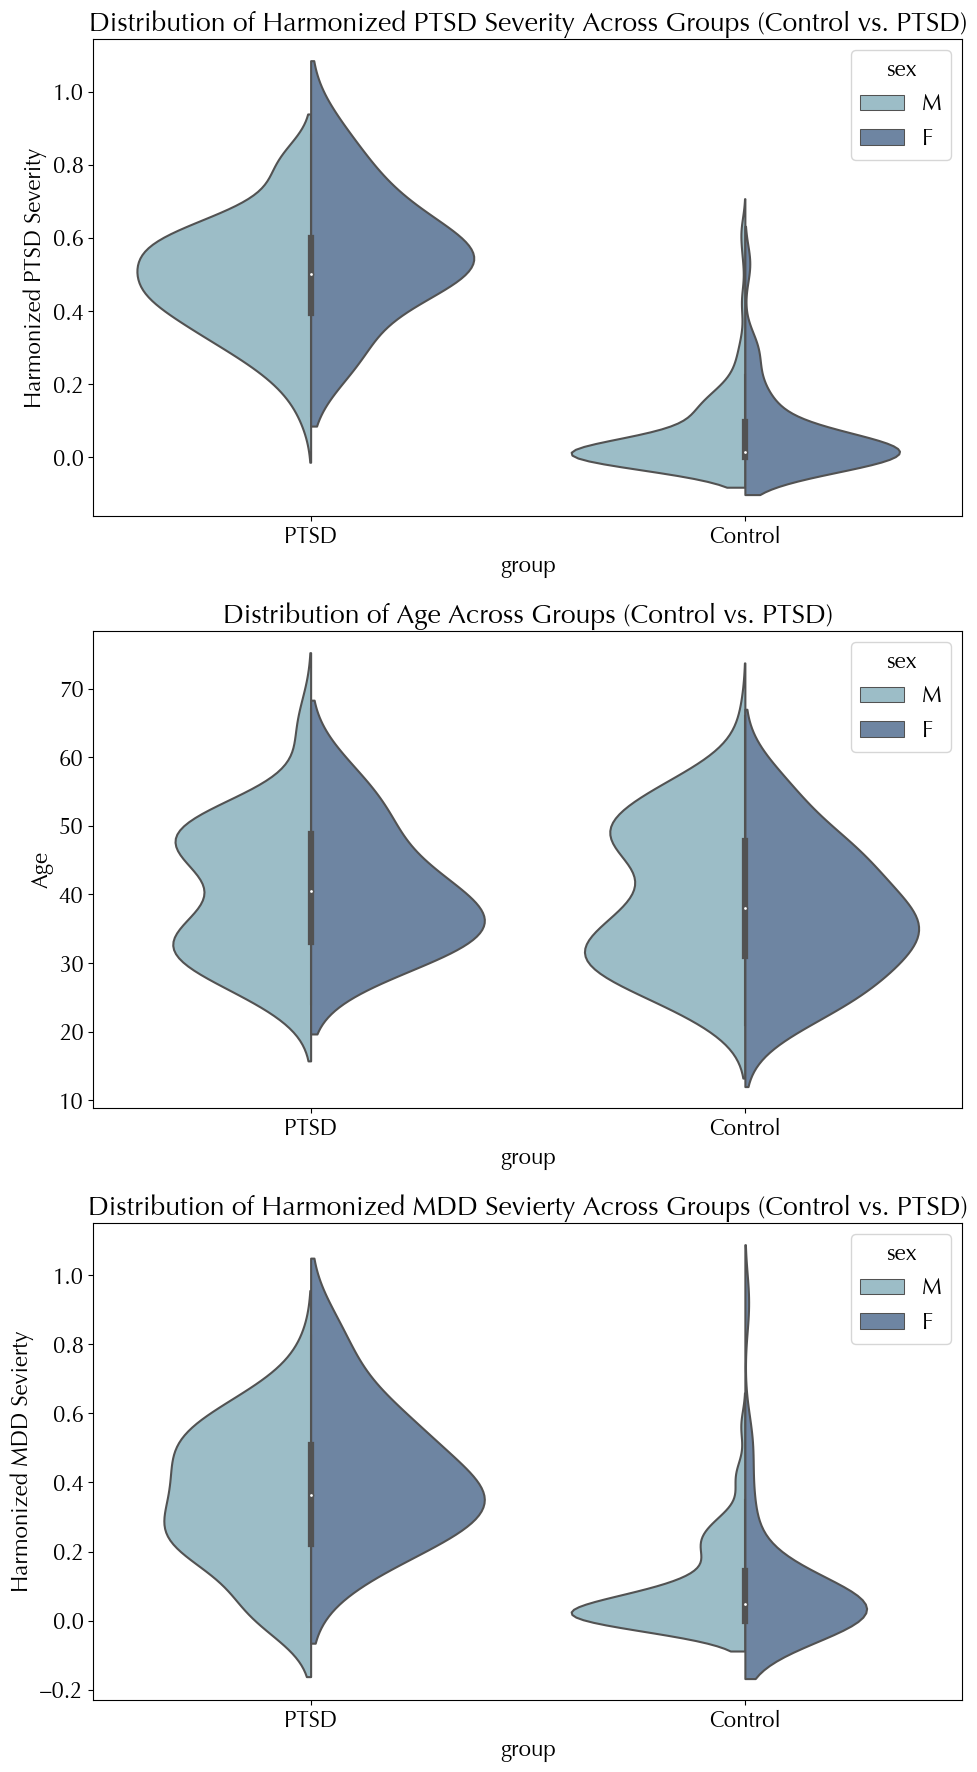

In [13]:
### Violin Plots
# Load the data
data_path = "Gyrification/merged_PTSD_ICV_Duke.xlsx"

df = pd.read_excel(data_path)

# Prepare the dataset for violin plots
plot_data_harmonized = df[['currentPTSD_dx', 'harmon_curr_ptsd_sev', 'age', 'sex', 'MDDpercent']]

# Filter out rows with missing values in relevant columns
plot_data_harmonized = plot_data_harmonized.dropna(subset=['currentPTSD_dx', 'harmon_curr_ptsd_sev', 'age', 'sex', 'MDDpercent'])

# Convert the "currentPTSD_dx" column to categorical labels ("Control" or "PTSD")
plot_data_harmonized['group'] = (
    plot_data_harmonized['currentPTSD_dx'].apply(lambda x: 'Control' if x == 0 else 'PTSD'))

data_range = (plot_data_harmonized['harmon_curr_ptsd_sev'].min(), plot_data_harmonized['harmon_curr_ptsd_sev'].max())
# Create a colormap based on the specified color parameters
cmap = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)

# Extract colors from the colormap and create a dictionary for the 'sex' variable
custom_palette = {'M': cmap(0.2), 'F': cmap(0.5)}
mpl.rcParams['font.size'] = 16

mpl.rcParams['font.family'] = 'Optima'

# Create violin plots for harmonized PTSD severity and age, stratified by group and sex
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 18))

# Plot the distribution of harmonized PTSD severity across groups, stratified by sex
sns.violinplot(x='group', y='harmon_curr_ptsd_sev', hue='sex', data=plot_data_harmonized, split=True, trim=True, palette=custom_palette, ax=axes[0])
axes[0].set_title('Distribution of Harmonized PTSD Severity Across Groups (Control vs. PTSD)')
axes[0].set_ylabel('Harmonized PTSD Severity')

# Plot the distribution of age across groups, stratified by sex
sns.violinplot(x='group', y='age', hue='sex', data=plot_data_harmonized, split=True, trim=True, palette=custom_palette, ax=axes[1])
axes[1].set_title('Distribution of Age Across Groups (Control vs. PTSD)')
axes[1].set_ylabel('Age')

# Plot the distribution of depression across groups, stratified by sex
sns.violinplot(x='group', y='MDDpercent', hue='sex', data=plot_data_harmonized, split=True, trim=True, palette=custom_palette, ax=axes[2])
axes[2].set_title('Distribution of Harmonized MDD Sevierty Across Groups (Control vs. PTSD)')
axes[2].set_ylabel('Harmonized MDD Sevierty')

plt.tight_layout()
plt.show()


In [ ]:
# Define the function to perform GLM and extract p-values for ROIs with significant p-values for harmon_curr_ptsd_sev
def perform_glm_and_extract_pvalues_for_rois(df, rois):
    # Define the independent variables
    independent_vars = ['ICV', 'sex', 'age', 'harmon_curr_ptsd_sev']
    
    # Initialize a dictionary to store p-values for ROIs
    roi_pvalues_for_harmon_curr_ptsd_sev = {}
    
    # Update the column names in the DataFrame
    df = df.rename(columns=lambda col: col.replace('.', '_'))
    
    # Loop through each ROI and perform GLM
    for roi in rois:
        # Exclude rows with missing data in the dependent or independent variables
        filtered_df = df[[roi] + independent_vars].dropna()
        
        # Create the formula for the GLM
        formula = f'{roi} ~ ICV + C(sex) + age + harmon_curr_ptsd_sev'
        
        # Perform GLM
        model = smf.glm(formula, data=filtered_df, family=sm.families.Gaussian()).fit()
        
        # Extract p-value for harmon_curr_ptsd_sev
        pvalue_harmon_curr_ptsd_sev = model.pvalues.get('harmon_curr_ptsd_sev', 1)
        
        # Store the p-value in the dictionary
        roi_pvalues_for_harmon_curr_ptsd_sev[roi] = pvalue_harmon_curr_ptsd_sev
    
    return roi_pvalues_for_harmon_curr_ptsd_sev

# Run the GLM analysis to identify ROIs with significant p-values
rois_with_significant_pvalues_for_harmon_curr_ptsd_sev = perform_glm_significant_for_harmon_curr_ptsd_sev(df)
# Update the column names in the list of ROIs
rois_with_significant_pvalues_for_harmon_curr_ptsd_sev_updated = [roi.replace('.', '_') for roi in rois_with_significant_pvalues_for_harmon_curr_ptsd_sev]
# Extract the p-values for the specified ROIs using the modified column names
roi_pvalues_for_harmon_curr_ptsd_sev = perform_glm_and_extract_pvalues_for_rois(df, rois_with_significant_pvalues_for_harmon_curr_ptsd_sev_updated)
roi_pvalues_for_harmon_curr_ptsd_sev


{'lh_precuneus': 0.015153596902412102,
 'rh_caudalmiddlefrontal': 0.04385473934941839,
 'rh_pericalcarine': 0.024071270823472855,
 'rh_postcentral': 0.029085332194997447}

In [ ]:
specified_rois = [
    'rh_caudalanteriorcingulate', 
    'rh_middletemporal', 
    'rh_parahippocampal', 
    'lh_caudalanteriorcingulate', 
    'lh_middletemporal', 
    'lh_parahippocampal'
]

# Extract the p-values for the specified ROIs using the original column names with periods
pvalues_for_specified_rois = perform_glm_and_extract_pvalues_for_rois(df, specified_rois)
pvalues_for_specified_rois

{'rh_caudalanteriorcingulate': 0.16422643721636287,
 'rh_middletemporal': 0.9223450742521326,
 'rh_parahippocampal': 0.5188925281726988,
 'lh_caudalanteriorcingulate': 0.7368393266797192,
 'lh_middletemporal': 0.49861113009188407,
 'lh_parahippocampal': 0.6724944577258447}

In [18]:


# Define the function to perform GLM and extract p-values for ROIs with significant p-values for MDDpercent
def perform_glm_and_extract_pvalues_for_rois(df, rois):

    independent_vars = ['ICV', 'sex', 'age', 'MDDpercent']
    
 
    roi_pvalues_for_MDDpercent = {}
    
    # Update the column names in the DataFrame
    df = df.rename(columns=lambda col: col.replace('.', '_'))
    

    for roi in rois:

        filtered_df = df[[roi] + independent_vars].dropna()
        
        # Create the formula for the GLM
        formula = f'{roi} ~ ICV + C(sex) + age + MDDpercent'
        
        # Perform GLM
        model = smf.glm(formula, data=filtered_df, family=sm.families.Gaussian()).fit()
        
        # Extract p-value for harmon_curr_ptsd_sev
        pvalue_MDDpercent = model.pvalues.get('MDDpercent', 1)
        
        # Store the p-value 
        roi_pvalues_for_MDDpercent[roi] = pvalue_MDDpercent
    
    return roi_pvalues_for_MDDpercent

# Run the GLM analysis to identify ROIs with significant p-values
rois_with_significant_pvalues_for_MDDpercent = perform_glm_significant_for_MDDpercent(df)
# Update the column names in the list of ROIs
rois_with_significant_pvalues_for_MDDpercent = [roi.replace('.', '_') for roi in rois_with_significant_pvalues_for_MDDpercent]
# Extract the p-values for the specified ROIs using the modified column names
roi_pvalues_for_MDDpercent = perform_glm_and_extract_pvalues_for_rois(df, rois_with_significant_pvalues_for_MDDpercent)
roi_pvalues_for_MDDpercent


{'lh_bankssts': 0.03863367277573359,
 'rh_superiorparietal': 0.04471459975774423}